# Basic Calculation

The `crystal17.basic` plugin is the simplest calculation plugin.
It accepts as input:

- a pre-written `main.d12` file and,
- (optionally) a `main.gui` file with geometry,
  to accompany a `main.d12` file containing the `EXTERNAL` keyword.

## Initial Setup

To run a computation, first ensure AiiDA is running:

In [1]:
!verdi status

 ✓ profile:     On profile test_profile
 ✓ repository:  /var/folders/dm/b2qnkb_n3r72slmpxlfmcjvm00lbnd/T/tmpwmy23te7/test_repo
 ✓ postgres:    Connected as aiida@localhost:55774
 ✓ rabbitmq:    Connected to amqp://127.0.0.1?heartbeat=600
 ✓ daemon:      Daemon is running as PID 60765 since 2019-08-06 20:43:17


.. seealso::

    AiiDA documentation: :ref:`aiida:quick_installation`

If `aiida-crystal17` is installed,
the `crystal17.basic` computation should be available:

In [2]:
!verdi plugin list aiida.calculations crystal17.basic

Inputs
            code:  required  Code            The Code to use for this job.
      input_file:  required  SinglefileData  the input .d12 file content.
  input_external:  optional  SinglefileData  optional input fort.34 (gui) file content (for use with EXTERNAL keyword).
        metadata:  optional                  
Outputs
   remote_folder:  required  RemoteData      Input files necessary to run the process will be stored in this folder node ...
         results:  required  Dict            the data extracted from the main output file
       retrieved:  required  FolderData      Files that are retrieved by the daemon will be stored in this node. By defa ...
       structure:  optional  StructureData   the structure output from the calculation
        symmetry:  optional  SymmetryData    the symmetry data from the calculation
Exit codes
               1:  The process has failed with an unspecified error.
               2:  The process failed with legacy failure mode.
              1

To use the python interface, first ensure a profile is loaded in the python kernel, and import the required modules:

In [1]:
from aiida import load_profile
profile = load_profile()
profile.name

'test_crystal17'

In [2]:
import os
from aiida_crystal17.common import display_json
from aiida_crystal17.tests import open_resource_binary
from aiida.orm import Code
from aiida.engine import run_get_node
from aiida.plugins import DataFactory

## Input Creation

.. seealso::

    AiiDA documentation: :ref:`aiida:setup_code`
    
    [CRYSTAL17 Manual](http://www.crystal.unito.it/Manuals/crystal17.pdf)

An :py:class:`~aiida.orm.nodes.data.code.Code` node should be set up in advance,
to use the `crystal17.basic` calculation plugin,
and call the ``runcry17`` executable
(or ``mock_runcry17`` used here for test purposes).

In [5]:
from aiida_crystal17.tests.utils import get_or_create_local_computer, get_or_create_code
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.basic', computer, 'mock_crystal17')
code.get_full_text_info()

[['PK', 1],
 ['UUID', '257d835a-5cae-44da-8d93-5a39a81510d0'],
 ['Label', 'crystal17.basic-mock_crystal17@localhost'],
 ['Description', ''],
 ['Default plugin', 'crystal17.basic'],
 ['Type', 'remote'],
 ['Remote machine', 'localhost'],
 ['Remote absolute path',
  '//anaconda/envs/aiida_crystal17/bin/mock_crystal17'],
 ['Prepend text', 'No prepend text'],
 ['Append text', 'No append text']]

An :py:class:`~aiida.orm.nodes.data.singlefile.SinglefileData` node is then set containing the main input file.

In [6]:
SinglefileData = DataFactory('singlefile')
with open_resource_binary('crystal', 'mgo_sto3g_scf', 'INPUT') as handle:
   infile = SinglefileData(file=handle)

with infile.open() as handle:
    print(handle.read())

MgO bulk
CRYSTAL
0 0 0
 225
4.21
2
 12 0.    0.    0.
  8 0.5   0.5   0.5
END
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.
8 2
1 0 3  2.  0.
1 1 3  6.  0.
99   0
END
SHRINK
8 8
END


## Setting Up and Running the Calculation

.. seealso::

    AiiDA documentation: :ref:`aiida:working_processes`

A builder can be obtained from the `Code` node,
which will define all the required input nodes and settings:

In [7]:
builder = code.get_builder()
builder.metadata.options.withmpi = False
builder.metadata.options.resources = {
    "num_machines": 1, 
    "num_mpiprocs_per_machine": 1}
builder.input_file = infile
display_json(builder)

```json
{
  "metadata": {
    "options": {
      "withmpi": false,
      "resources": {
        "num_machines": 1,
        "num_mpiprocs_per_machine": 1
      }
    }
  },
  "code": [
    "Remote code 'crystal17.basic-mock_crystal17@localhost' on localhost,",
    "pk: 1, uuid: 257d835a-5cae-44da-8d93-5a39a81510d0"
  ],
  "input_file": [
    "uuid: 8f9df231-3177-486b-9d2b-10909747fcb6 (unstored)"
  ]
}
```

In order to run the computation,
the builder can be parsed to one of the AiiDA ``run`` (blocking execution) or ``submit`` (non-blocking execution) functions:

In [8]:
result, calcnode = run_get_node(builder)

The process can be monitored on the command line:

In [9]:
!verdi process list -a -l 1 -D desc

  PK  Created    Process label        Process State    Process status
----  ---------  -------------------  ---------------  ----------------
   3  16s ago    CryBasicCalculation  ⏹ Finished [0]

Total results: 1

Info: last time an entry changed state: 3s ago (at 19:43:40 on 2019-08-06)


Once the calculation is complete, a ``CalcJobNode`` will be created,
to store the settings and outcome of the computation.
Crucially, if the computation has completed successfully,
the `exit_status` will be **0**. 

This can be assessed on the command line or with the python API.

In [10]:
!verdi process show {calcnode.pk}

Property       Value
-------------  ------------------------------------
type           CalcJobNode
pk             3
uuid           1bb02f0c-16ab-44cb-944a-615ef6de67bc
label
description
ctime          2019-08-06 19:43:26.643647+00:00
mtime          2019-08-06 19:43:40.222384+00:00
process state  Finished
exit status    0
computer       [1] localhost

Inputs        PK  Type
----------  ----  --------------
code           1  Code
input_file     2  SinglefileData

Outputs          PK  Type
-------------  ----  -------------
remote_folder     4  RemoteData
results           6  Dict
retrieved         5  FolderData
structure         7  StructureData
symmetry          8  SymmetryData


In [11]:
print(calcnode.is_finished_ok)
print(calcnode.process_state)
print(calcnode.exit_status)

True
ProcessState.FINISHED
0


If the calculation fails, there are three things that should be checked:

1. The calculation's exit_message
2. The calculation's log messages and scheduler output
3. The `results` output node (if available)

In [12]:
print("Exit Message:", calcnode.exit_message)
from aiida.cmdline.utils.common import get_calcjob_report
print(get_calcjob_report(calcnode))

Exit Message: None
*** 3: None
*** (empty scheduler output file)
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


In [13]:
!verdi process report {calcnode.pk}

*** 3: None
*** (empty scheduler output file)
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


##  Analysis of Outputs

The :py:class:`aiida.tools.visualization.graph.Graph` can be used to visualise the calculations provenance graph:

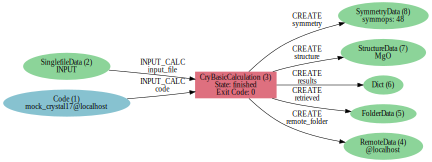

In [14]:
from aiida.tools.visualization import Graph
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode)
graph.add_incoming(calcnode, annotate_links="both")
graph.add_outgoing(calcnode, annotate_links="both")
graph.graphviz

The `retrieved` `FolderData` output node contains the CRYSTAL17 main output file.

In [15]:
calcnode.outputs.retrieved.list_object_names()

['_scheduler-stderr.txt', '_scheduler-stdout.txt', 'main.out']

The `results` `Dict` output node contains key values extracted from the CRYSTAL17 main output file.

In [16]:
display_json(calcnode.outputs.results.attributes)

```json
{
  "units": {
    "angle": "degrees",
    "energy": "eV",
    "length": "angstrom",
    "conversion": "CODATA2014"
  },
  "energy": -7380.2216051903,
  "errors": [],
  "header": {
    "crystal_version": 17,
    "crystal_subversion": "1.0.1"
  },
  "volume": 18.65461525,
  "warnings": [],
  "calculation": {
    "n_ao": 14,
    "spin": false,
    "type": "restricted closed shell",
    "n_atoms": 2,
    "n_shells": 5,
    "n_symops": 48,
    "n_core_el": 12,
    "n_electrons": 20,
    "n_kpoints_ibz": 29,
    "n_kpoints_gilat": 29
  },
  "energy_units": "eV",
  "parser_class": "CryMainParser",
  "parser_errors": [],
  "parser_version": "0.10.0b5",
  "scf_iterations": 7,
  "number_of_atoms": 2,
  "parser_warnings": [
    "no initial structure available, creating new kinds for atoms"
  ],
  "parser_exceptions": [],
  "number_of_assymetric": 2,
  "execution_time_seconds": 3
}
```

The `structure` `StructureData` output node contains the final structure,
obtained from the CRYSTAL17 main output file.

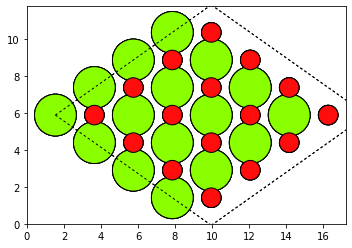

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
atoms = calcnode.outputs.structure.get_ase()
fig, ax = plt.subplots()
plot_atoms(atoms.repeat((4,4,4)), 
           ax, radii=0.8, show_unit_cell=True, 
           rotation=('45x,0y,0z'));

The `symmetry` `SymmetryData` output node contains the symmetry of the final structure,
obtained from the CRYSTAL17 main output file.

In [18]:
print(calcnode.outputs.symmetry.attributes)
calcnode.outputs.symmetry.data.operations

{'basis': 'fractional', 'num_symops': 48, 'hall_number': None}


[[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0],
 [-1.0, -1.0, -1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, -1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [-1.0, -1.0, -1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [-1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0],
 [-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, -1.0, 1.0, 1.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0,